# Features engineering

Transforming the enough raw data in the format depending on the selected model. This is the art of ML, when expertise matters and what most applied ML learning engineers do.

In [8]:
# Add local modules
import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

## Missing data

### Reason

- Completely random (MCAR): unsystematic 
- Random (MAR): reason of missing data has a pattern but is external to the observed variables
- Not at random (MNAR): missing data is related to observed variables

### Inputing

In general, it's possible to replace by the mean (**input**) or the median for numerical variable or the mode for categorical but that leads to inconsistent data as it doesn't consider its relations with other variables. **Droping** rows is possible if you have enough data but that can bias the dataset in general or **substitute** using a similar column. 

The best option is to using ML itself:
- KNN: Imputes missing values using k-Nearest Neighbors
- Deep learning for categorical data
- MICE: Multiple iterations of regression models where each missing values in a variable are infered depending on the variables, assumes missing values are MAR and missing values are initialized through simple imputation before starting to iterate

Below, an example compairing simple imputation and KNN.

In [7]:
import numpy as np

from sklearn.impute import SimpleImputer, KNNImputer

X = [[7, 2, np.nan], [4, np.nan, 6], [10, 5, 9], [4, 2, 8]]
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_knn = KNNImputer(missing_values=np.nan, n_neighbors=2)

imp_mean.fit_transform(X), imp_knn.fit_transform(X)

(array([[ 7.,  2.,  8.],
        [ 4.,  2.,  6.],
        [10.,  5.,  9.],
        [ 4.,  2.,  8.]]),
 array([[ 7. ,  2. ,  8.5],
        [ 4. ,  2. ,  6. ],
        [10. ,  5. ,  9. ],
        [ 4. ,  2. ,  8. ]]))

## Dimensionality reduction

Why? the more data the more computation needed (not linearly!) and eventually more noise. Therefore, we need to remove the noise and select what has information.

Below an exaple to use PCA within a ML pipeline.


In [2]:
# PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest

# Load data
X,y = make_classification(n_informative=5, n_redundant=2, n_repeated=2,\
                          n_classes=4, n_clusters_per_class=2)

# Define steps
pca = PCA(n_components=2)
selection = SelectKBest(k=1)
combined_features = FeatureUnion([("pca", pca), ("select", selection)])
classifier = RandomForestClassifier()

# Grid search 
n_components = [1, 3, 5, 10]
select_k=[1, 3, 5, 10]
pipeline = Pipeline([("features", combined_features), ("classifier", classifier)])
param_grid = dict(features__pca__n_components=n_components,
                  features__select__k=select_k)

grid_search = GridSearchCV(pipeline, param_grid=param_grid).fit(X, y)


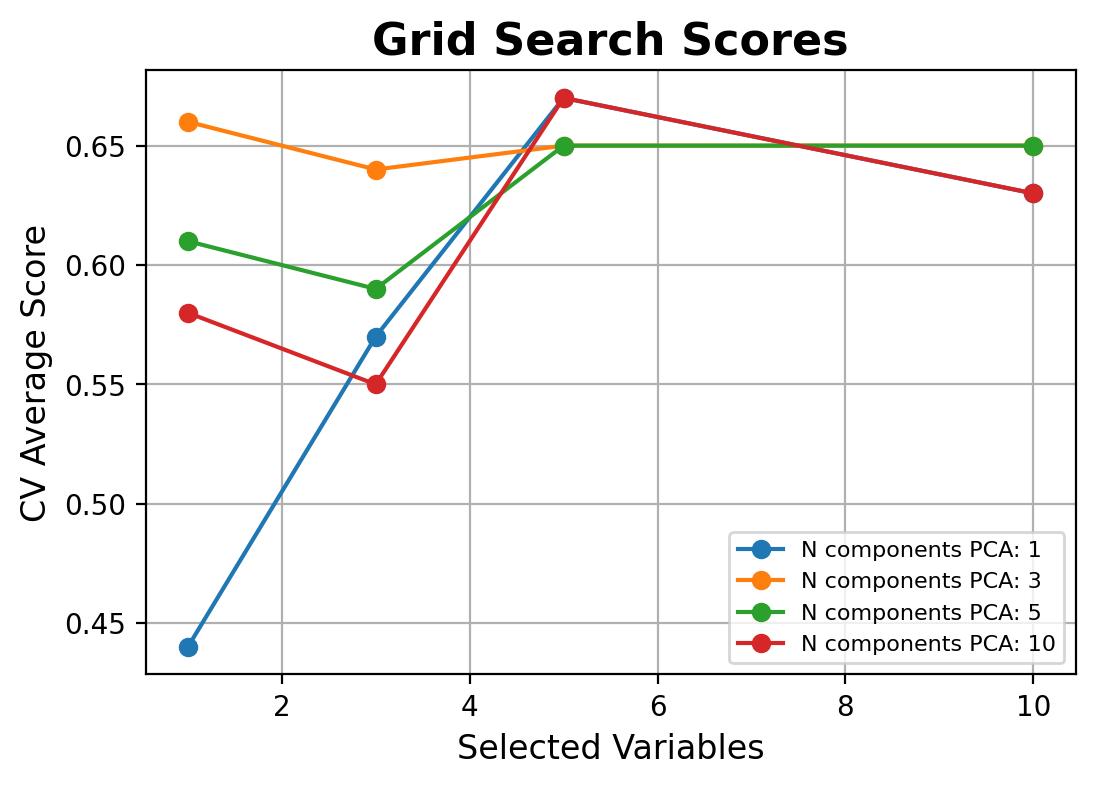

In [3]:
from src.data_analysis import plot_grid_search

plot_grid_search(grid_search.cv_results_, [n_components, select_k], ['N components PCA', 'Selected Variables'])

## Outliers

## Unbalanced datasets

Normally a problem for anomaly detection where we have few samples of the class to be detected.

Techniques for balancing:
- Undersampling: drop rows of the classes with more samples in the trainging dataset
- Oversampling: duplicate rows of the minority class in the trainging dataset
- Adjust thresohld: probability of being in a class, it may increase false 
- SMOTE (Synthetic Minority Oversampling Technique): creates new rows using KNN
- ADASYN (Adaptive Synthetic): Initialize as SMOTE and then creates new rows focusing on classes that are difficult to learn (which are the minority within a neighborhood)

You can see a comparison between the last two using the **imblearn** library.

In [3]:
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE, ADASYN

X, y = make_classification(n_samples=2000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.04, 0.96],
                           class_sep=0.7, random_state=0)

X_resampled, y_resampled = SMOTE().fit_resample(X, y)
clf_smote = LinearSVC().fit(X_resampled, y_resampled)

X_resampled, y_resampled = ADASYN().fit_resample(X, y)
clf_adasyn = LinearSVC().fit(X_resampled, y_resampled)

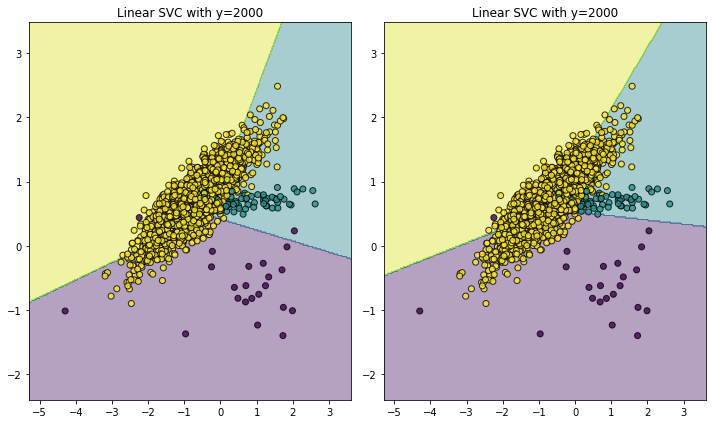

In [11]:
import matplotlib.pyplot as plt

from src.modelling import plot_decision_function

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax_arr = (ax1, ax2)
cls_arr = (clf_smote, clf_adasyn)

for ax, clf in zip(ax_arr, cls_arr):
    plot_decision_function(X, y, clf, ax)
    ax.set_title('Linear SVC with y={}'.format(len(y)))
fig.tight_layout()